In [1]:
import sys
import math
import random
import time
from PIL import Image
#import Queue
import numpy as np
import threading
#from cStringIO import StringIO
from io import StringIO
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
import requests
from io import BytesIO
import io
import PIL

In [2]:
from google.colab import drive
drive.mount('/content/drive')

#workdir = '/content/drive/MyDrive/dataset_ml/amazon_men_actualizado/' #mario


Mounted at /content/drive


In [ ]:
!wget http://cseweb.ucsd.edu/~wckang/DVBPR/AmazonMenWithImgPartitioned.npy

--2021-12-01 06:45:27--  http://cseweb.ucsd.edu/~wckang/DVBPR/AmazonMenWithImgPartitioned.npy
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cseweb.ucsd.edu//~wckang/DVBPR/AmazonMenWithImgPartitioned.npy [following]
--2021-12-01 06:45:27--  https://cseweb.ucsd.edu//~wckang/DVBPR/AmazonMenWithImgPartitioned.npy
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2276159058 (2.1G)
Saving to: ‘AmazonMenWithImgPartitioned.npy’

AmazonMenWithImgPar 100%[===================>]   2.12G  16.0MB/s    in 2m 9s   

2021-12-01 06:47:36 (16.9 MB/s) - ‘AmazonMenWithImgPartitioned.npy’ saved [2276159058/2276159058]



In [ ]:
dataset_name = "AmazonMenWithImgPartitioned.npy"
#dataset_name = "AmazonWomenWithImgPartitioned.npy"

#Hyper-prameters
K = 5#100 # Latent dimensionality
lambda1 = 0.001 # Weight decay
lambda2 = 1.0 # Regularizer for theta_u
learning_rate = 1e-4
training_epoch = 2 #20
batch_size = 4000 #128
dropout = 0.5 # Dropout, probability to keep units
numldprocess=4 # multi-threading for loading images


dataset = np.load(dataset_name,allow_pickle=True,encoding='bytes')

[user_train, user_validation, user_test, Item, usernum, itemnum] = dataset

# Pre-procesamiento de datos Amazon-men

In [ ]:
#Se seleccionan items de determinadas categorias, como poleras, camisas, etc.

seleccionados = []

for item in Item:
  for n_list in range(len(Item[item][b'categories'])):
    if (b'T-Shirts' in Item[item][b'categories'][n_list]) or (b'Shirts' in Item[item][b'categories'][n_list]) or (b'Casual Button-Down Shirts' in Item[item][b'categories'][n_list]) or (b'Polos' in Item[item][b'categories'][n_list]) or (b'Outerwear' in Item[item][b'categories'][n_list]) or (b'Active' in Item[item][b'categories'][n_list]):
      seleccionados.append(item)

print("La cantidad de items de la categoria T-Shirts: ", len(seleccionados))

La cantidad de items de la categoria T-Shirts:  29588


In [ ]:
#Se agrupan todos los datos de train, test y validacion en un solo diccionario
todo = {}

for user in user_train:
  todo[user] = user_train[user] + user_test[user] + user_validation[user]

In [ ]:
#del diccionario anterior se seleccionan sólo los usuarios que han puntuado con 4 o 5 estrellas

filtrado={}

for u in range(usernum):
    for item in todo[u]:
        if item['overall'] >= 4 : #tiene rating igual a 5
            if u not in filtrado.keys():
                filtrado[u]=[item]
            else:
                filtrado[u].append(item)

In [ ]:
#Se crea un diccionario que contiene usuarios que han comprado los items de las categorias seleccionadas 
#y los han puntuado con 4 o 5 estrellas

dic_interacciones_tshirt={}

for user in filtrado.keys():
  for item in range(len(filtrado[user])):
    if filtrado[user][item][b'productid'] in seleccionados:
      if user not in dic_interacciones_tshirt.keys():
        dic_interacciones_tshirt[user]=[filtrado[user][item]]
      else:
        dic_interacciones_tshirt[user].append(filtrado[user][item])

In [ ]:
#validos son los usuarios con 3 o mas interacciones, que han puesto ratings 4 o 5 y han comprado las categorias escogidas

validos = {}

for user in dic_interacciones_tshirt:
  if len(dic_interacciones_tshirt[user])>2:
    validos[user] = dic_interacciones_tshirt[user]

In [ ]:
#diccionario que muestra {usuario: [productid1, productid2,...]} 

lista_user_item = {}

for user in validos:
  for item in range(len(validos[user])):
    if user not in lista_user_item.keys():
      lista_user_item[user] = [validos[user][item][b'productid']]
    else:
      lista_user_item[user].append(validos[user][item][b'productid'])

In [ ]:
#Muestra con qué usuarios y en qué items el usuario u tiene intersección.
#{user_u = (user_v, {item_i})}

interseccion = {}

for user in range(len(lista_user_item)):
  usuario = list(lista_user_item.keys())[user]
  for otro_user in list(lista_user_item.keys())[user+1:]:
    if set(lista_user_item[usuario])&set(lista_user_item[otro_user]) != set():
      if usuario not in interseccion.keys():
        interseccion[usuario] = [(otro_user, set(lista_user_item[usuario])&set(lista_user_item[otro_user]))]
      else:
        interseccion[usuario].append((otro_user, set(lista_user_item[usuario])&set(lista_user_item[otro_user])))
  

In [ ]:
test = []

for user in interseccion:
  if len(interseccion[user][0][1]) == 1:
    test.append((user, interseccion[user][0][1]))
  else:
    test.append((user, {list(interseccion[user][0][1])[0]}))

In [ ]:
train = []

for user, i in test:
  item = list(i)[0]
  for it in lista_user_item[user]:
    if it != item:
      train.append((user, {it}))

In [ ]:
dic_train = {}

for user, i in train:
  item = list(i)[0]
  for j in range(len(validos[user])):
    if validos[user][j][b'productid'] == item:
      if user not in dic_train.keys():
        dic_train[user] = [validos[user][j]]
      else:
        dic_train[user].append(validos[user][j])

In [ ]:
dic_test = {}

for user, i in test:
  item = list(i)[0]
  for j in range(len(validos[user])):
    if validos[user][j][b'productid'] == item:
      if user not in dic_test.keys():
        dic_test[user] = [validos[user][j]]
      else:
        dic_test[user].append(validos[user][j])

In [ ]:
np.save('dic_train_men.npy', dic_train) 
np.save('dic_test_men.npy', dic_test) 

In [3]:
dic_train = np.load(workdir + 'dic_train_men.npy',allow_pickle='TRUE')
dic_train=list(dic_train.reshape(-1,1))[0][0]

dic_test = np.load(workdir + 'dic_test_men.npy',allow_pickle='TRUE')
dic_test=list(dic_test.reshape(-1,1))[0][0]

## Análisis exploratorio de datos

**Usuarios:** 3834

**Items:** 9106

**Interacciones:** 12884

**Sparcity:** 0.037%

**Max interacciones:** 38

**Min interacciones:** 2

**Coldstart:** 2.9%

In [8]:
print("Cantidad de usuarios:", len(dic_train))

#Cuenta la cantidad de items en Train
items = set()
for user in dic_train:
  #items.add(dic_test[user][0][b'productid'])
  for item in range(len(dic_train[user])):
    items.add(dic_train[user][item][b'productid'])

print("Cantidad de items:", len(items))

#Cuenta la cantidad de iteracciones usuario-item en Train

int_ = 0

for user in dic_train:
  int_+= len(dic_train[user])

print("Cantidad de interacciones:", int_)

#Calcula Sparcity

print("Sparcity:", int_/(len(items)*len(dic_train))*100, "%")

#Calcula maximo y minimo de interacciones

dic_int = {}

for user in dic_train:
  dic_int[user]=len(dic_train[user])

int_max = np.max(list(dic_int.values()))
int_min = np.min(list(dic_int.values()))

print("Usuario con mayor cantidad de interacciones:", int_max)
print("Usuario con menor cantidad de interacciones:", int_min)

coldstart = 0

for user in dic_test:
  if dic_test[user][0][b'productid'] not in items:
    coldstart+=1

print("Coldstart:", coldstart/len(items)*100)

Cantidad de usuarios: 3834
Cantidad de items: 9106
Cantidad de interacciones: 12884
Sparcity: 0.0369037892664166 %
Usuario con mayor cantidad de interacciones: 38
Usuario con menor cantidad de interacciones: 2
Coldstart: 2.888205578739293


In [ ]:
df_train = pd.DataFrame(columns=['user_id', 'product_id', 'rating'])
k=0

for user in dic_train:
  for item in range(len(dic_train[user])):
    df_train.loc[k] = [user, dic_train[user][item][b'productid'], dic_train[user][item]['overall']]
    k+=1

In [ ]:
df_test = pd.DataFrame(columns=['user_id', 'product_id', 'rating'])
k=0

for user in dic_test:
  for item in range(len(dic_test[user])):
    df_test.loc[k] = [user, dic_test[user][item][b'productid'], dic_test[user][item]['overall']]
    k+=1

In [ ]:
df_train.to_csv('df_train.csv', header=True)
df_test.to_csv('df_test.csv', header=True)

## Distribución de interacciones por item

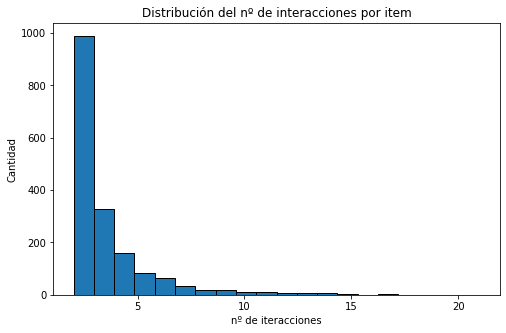

In [ ]:
plt.figure(figsize=(8,5))

plt.hist(df_train["product_id"].value_counts(), bins=20, range= [2,21], ec='k')
plt.xlabel('nº de iteracciones')
plt.ylabel('Cantidad')
plt.title("Distribución del nº de interacciones por item")
plt.locator_params(axis='x', integer=True)
plt.show()

## Distribución de interacciones por usuario

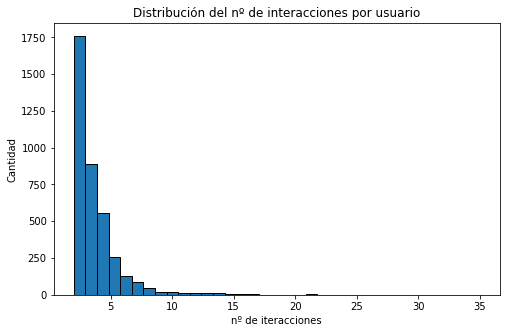

In [ ]:
plt.figure(figsize=(8,5))

plt.hist(df_train["user_id"].value_counts(), bins = 35, range= [2,35], ec= 'k')
plt.xlabel('nº de iteracciones')
plt.ylabel('Cantidad')
plt.title("Distribución del nº de interacciones por usuario")
plt.show()

# Pre-procesamiento de datos Amazon-women

In [ ]:
!wget http://cseweb.ucsd.edu/~wckang/DVBPR/AmazonWomenWithImgPartitioned.npy 

--2021-12-01 06:15:20--  http://cseweb.ucsd.edu/~wckang/DVBPR/AmazonWomenWithImgPartitioned.npy
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cseweb.ucsd.edu//~wckang/DVBPR/AmazonWomenWithImgPartitioned.npy [following]
--2021-12-01 06:15:21--  https://cseweb.ucsd.edu//~wckang/DVBPR/AmazonWomenWithImgPartitioned.npy
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6644545540 (6.2G)
Saving to: ‘AmazonWomenWithImgPartitioned.npy.1’

AmazonWomenWithImgP 100%[===================>]   6.19G  19.1MB/s    in 7m 47s  

2021-12-01 06:23:08 (13.6 MB/s) - ‘AmazonWomenWithImgPartitioned.npy.1’ saved [6644545540/6644545540]



In [ ]:
#dataset_name = "AmazonMenWithImgPartitioned.npy"
dataset_name = "AmazonWomenWithImgPartitioned.npy"

#Hyper-prameters
K = 5#100 # Latent dimensionality
lambda1 = 0.001 # Weight decay
lambda2 = 1.0 # Regularizer for theta_u
learning_rate = 1e-4
training_epoch = 2 #20
batch_size = 4000 #128
dropout = 0.5 # Dropout, probability to keep units
numldprocess=4 # multi-threading for loading images


dataset = np.load(dataset_name,allow_pickle=True,encoding='bytes')

[user_train, user_validation, user_test, Item, usernum, itemnum] = dataset

In [ ]:
#or (b'Leggings' in Item[item][b'categories'][n_list]) or (b'Dresses' in Item[item][b'categories'][n_list]) or (b'Active' in Item[item][b'categories'][n_list])

In [ ]:
#Se seleccionan items de determinadas categorias, como poleras, camisas, etc.

seleccionados = []

for item in Item:
  for n_list in range(len(Item[item][b'categories'])):
    if (b'T-Shirts' in Item[item][b'categories'][n_list]) or (b'Shirts' in Item[item][b'categories'][n_list]) or (b'Casual Button-Down Shirts' in Item[item][b'categories'][n_list]) or (b'Polos' in Item[item][b'categories'][n_list]) or (b'Outerwear' in Item[item][b'categories'][n_list]) or ( b'Tops & Tees' in Item[item][b'categories'][n_list]) or (b'Knits & Tees' in Item[item][b'categories'][n_list]):
      seleccionados.append(item)

print("La cantidad de items de la categoria T-Shirts: ", len(seleccionados))

La cantidad de items de la categoria T-Shirts:  37892


In [ ]:
#Se agrupan todos los datos de train, test y validacion en un solo diccionario
todo = {}

for user in user_train:
  todo[user] = user_train[user] + user_test[user] + user_validation[user]

In [ ]:
#del diccionario anterior se seleccionan sólo los usuarios que han puntuado con 4 o 5 estrellas

filtrado={}

for u in range(usernum):
    for item in todo[u]:
        if item['overall'] >= 4 : #tiene rating igual a 5
            if u not in filtrado.keys():
                filtrado[u]=[item]
            else:
                filtrado[u].append(item)

In [ ]:
#Se crea un diccionario que contiene usuarios que han comprado los items de las categorias seleccionadas 
#y los han puntuado con 4 o 5 estrellas

dic_interacciones_tshirt={}

for user in filtrado.keys():
  for item in range(len(filtrado[user])):
    if filtrado[user][item][b'productid'] in seleccionados:
      if user not in dic_interacciones_tshirt.keys():
        dic_interacciones_tshirt[user]=[filtrado[user][item]]
      else:
        dic_interacciones_tshirt[user].append(filtrado[user][item])

In [ ]:
#validos son los usuarios con 3 o mas interacciones, que han puesto ratings 4 o 5 y han comprado las categorias escogidas

validos = {}

for user in dic_interacciones_tshirt:
  if len(dic_interacciones_tshirt[user])>2:
    validos[user] = dic_interacciones_tshirt[user]

In [ ]:
#diccionario que muestra {usuario: [productid1, productid2,...]} 

lista_user_item = {}

for user in validos:
  for item in range(len(validos[user])):
    if user not in lista_user_item.keys():
      lista_user_item[user] = [validos[user][item][b'productid']]
    else:
      lista_user_item[user].append(validos[user][item][b'productid'])

In [ ]:
#Muestra con qué usuarios y en qué items el usuario u tiene intersección.
#{user_u = (user_v, {item_i})}

interseccion = {}

for user in range(len(lista_user_item)):
  usuario = list(lista_user_item.keys())[user]
  for otro_user in list(lista_user_item.keys())[user+1:]:
    if set(lista_user_item[usuario])&set(lista_user_item[otro_user]) != set():
      if usuario not in interseccion.keys():
        interseccion[usuario] = [(otro_user, set(lista_user_item[usuario])&set(lista_user_item[otro_user]))]
      else:
        interseccion[usuario].append((otro_user, set(lista_user_item[usuario])&set(lista_user_item[otro_user])))

In [ ]:
test = []

for user in interseccion:
  if len(interseccion[user][0][1]) == 1:
    test.append((user, interseccion[user][0][1]))
  else:
    test.append((user, {list(interseccion[user][0][1])[0]}))

In [ ]:
train = []

for user, i in test:
  item = list(i)[0]
  for it in lista_user_item[user]:
    if it != item:
      train.append((user, {it}))

In [ ]:
dic_train = {}

for user, i in train:
  item = list(i)[0]
  for j in range(len(validos[user])):
    if validos[user][j][b'productid'] == item:
      if user not in dic_train.keys():
        dic_train[user] = [validos[user][j]]
      else:
        dic_train[user].append(validos[user][j])

In [ ]:
dic_test = {}

for user, i in test:
  item = list(i)[0]
  for j in range(len(validos[user])):
    if validos[user][j][b'productid'] == item:
      if user not in dic_test.keys():
        dic_test[user] = [validos[user][j]]
      else:
        dic_test[user].append(validos[user][j])

In [ ]:
np.save('dic_train_women.npy', dic_train) 
np.save('dic_test_women.npy', dic_test) 

In [9]:
workdir = '/content/drive/MyDrive/ANN-2021-I/women/'

dic_train = np.load(workdir + 'dic_train_women.npy',allow_pickle='TRUE')
dic_train=list(dic_train.reshape(-1,1))[0][0]

dic_test = np.load(workdir + 'dic_test_women.npy',allow_pickle='TRUE')
dic_test=list(dic_test.reshape(-1,1))[0][0]

## Análisis exploratorio de datos

**Usuarios:** 3158

**Items:** 7245

**Interacciones:** 11350

**Sparcity:** 0.05%

**Max interacciones:** 90

**Min interacciones:** 2

**Coldstart:** 2.7%

In [10]:
print("Cantidad de usuarios:", len(dic_train))

#Cuenta la cantidad de items en Train
items = set()
for user in dic_train:
  #items.add(dic_test[user][0][b'productid'])
  for item in range(len(dic_train[user])):
    items.add(dic_train[user][item][b'productid'])

print("Cantidad de items:", len(items))

#Cuenta la cantidad de iteracciones usuario-item en Train

int_ = 0

for user in dic_train:
  int_+= len(dic_train[user])

print("Cantidad de interacciones:", int_)

#Calcula Sparcity

print("Sparcity:", int_/(len(items)*len(dic_train))*100, "%")

#Calcula maximo y minimo de interacciones

dic_int = {}

for user in dic_train:
  dic_int[user]=len(dic_train[user])

int_max = np.max(list(dic_int.values()))
int_min = np.min(list(dic_int.values()))

print("Usuario con mayor cantidad de interacciones:", int_max)
print("Usuario con menor cantidad de interacciones:", int_min)

coldstart = 0

for user in dic_test:
  if dic_test[user][0][b'productid'] not in items:
    coldstart+=1

print("Coldstart:", coldstart/len(items)*100)

Cantidad de usuarios: 3158
Cantidad de items: 7245
Cantidad de interacciones: 11350
Sparcity: 0.04960727212014488 %
Usuario con mayor cantidad de interacciones: 90
Usuario con menor cantidad de interacciones: 2
Coldstart: 2.7743271221532093


In [ ]:
df_train = pd.DataFrame(columns=['user_id', 'product_id', 'rating'])
k=0

for user in dic_train:
  for item in range(len(dic_train[user])):
    df_train.loc[k] = [user, dic_train[user][item][b'productid'], dic_train[user][item]['overall']]
    k+=1

In [ ]:
df_test = pd.DataFrame(columns=['user_id', 'product_id', 'rating'])
k=0

for user in dic_test:
  for item in range(len(dic_test[user])):
    df_test.loc[k] = [user, dic_test[user][item][b'productid'], dic_test[user][item]['overall']]
    k+=1

In [ ]:
df_train.to_csv('df_train_women.csv', header=True)
df_test.to_csv('df_test_women.csv', header=True)

## Distribución de interacciones por item

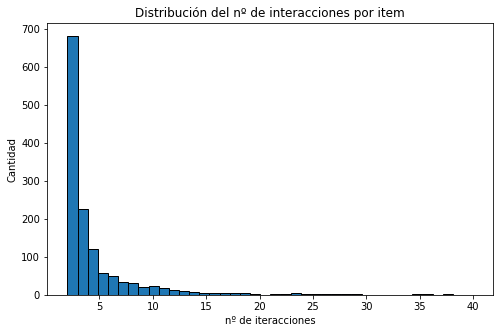

In [ ]:
plt.figure(figsize=(8,5))

plt.hist(df_train["product_id"].value_counts(), bins=40, range= [2,40], ec='k')
plt.xlabel('nº de iteracciones')
plt.ylabel('Cantidad')
plt.title("Distribución del nº de interacciones por item")
plt.locator_params(axis='x', integer=True)
plt.show()

## Distribución de interacciones por usuario

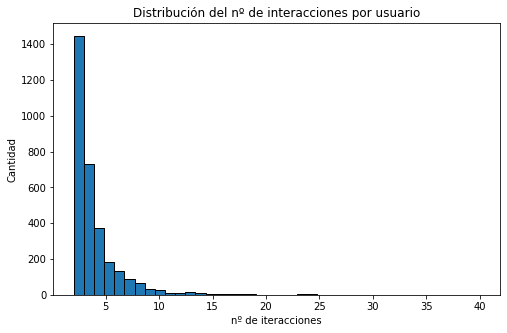

In [ ]:
plt.figure(figsize=(8,5))

plt.hist(df_train["user_id"].value_counts(), bins = 40, range= [2,40], ec= 'k')
plt.xlabel('nº de iteracciones')
plt.ylabel('Cantidad')
plt.title("Distribución del nº de interacciones por usuario")
plt.show()